### Instruct finetuning

When a large language model is trained ,what it is essentially trained for is text completion. However model's are trained to follow instructions provided by us as prompts

There are different stages for instruction finetuning a model.
- Preparing a dataset
- Finetuning a LLM
- Evaluating the LLM

### Preparing a dataset

In [1]:
import json
import os
import urllib

In [2]:
def download_and_load_file(file_path,url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w',encoding='utf-8') as file:
            file.write(text_data)
    else:
        with open(file_path,"r",encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path,"r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
"/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
def inspect_dataset(data,indexes):
    for index in indexes:
        print("\n".join(f"{key}: {value}" for key, value in data[index].items()))
        print("*"*50)

indexes = [455,912,754]
inspect_dataset(data,indexes)

instruction: Name a synonym for 'exciting'.
input: 
output: A synonym for 'exciting' is 'thrilling'.
**************************************************
instruction: Convert 5 kilograms to grams.
input: 
output: 5 kilograms is 5000 grams.
**************************************************
instruction: Convert 3 liters to milliliters.
input: 
output: 3 liters is 3000 milliliters.
**************************************************


-   From what we can see by inspecting the dataset, the dataset consists of simple basic instructions. Occasionally the input fields are empty as well. 

Instruction fine-tuning involves training a model on dataset where input-output pairs are provided. There are various prompt styles of instruct finetuning model.

[Alpaca](https://crfm.stanford.edu/2023/03/13/alpaca.html) was one of the initial models released and we would be following the same style of prompt for instruction finetuning through this notebook.

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes as task. "
        f"Write a response that approximately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

In [5]:
model_input = format_input(data[259])
desired_response = f"\n\n### Response:\n{data[259]['output']}"
print(model_input + desired_response)

Below is an instruction that describes as task. Write a response that approximately completes the request.

### Instruction:
Provide a word that rhymes with "care."

### Response:
A word that rhymes with "care" is "fare."


In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Train data:", len(train_data))
print("Test data:", len(test_data))
print("Validation data:", len(val_data))

Train data: 935
Test data: 110
Validation data: 55


#### Batching the data:

When dealing with this dataset, the input-output pairs are not of the same size and vary. Inorder to treat them the same way and also to make the training process efficient we get to batch the data. The steps needs to be done are:
- tokenize the formatted data
- use the pad tokens to make the input-output pairs of the same size
- create target-IDs for training
- finally exclude the padding tokens in loss function calculation by adding in placeholders.

In [7]:
import torch
from torch.utils.data import Dataset

In [8]:
class InstructionDataset(Dataset):
    def __init__(self,data,tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.encoded_texts[index]

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device="cpu"):
    """
    Used to find the largest sequence in the batch and pad all sequences to that length.
    
    """
    batch_max_length = max(len(item)+1 for item in batch)
    input_list = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        input_list.append(inputs)

    input_tensor = torch.stack(input_list).to(device)
    return input_tensor

In [11]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


- We are now able to format the data using a prompt template , encode them and adjust them based on the length.
- Need to create target tokenid's for training and replace them with padding tokens with placeholders.

In [12]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device="cpu"):
    """
    Used to find the largest sequence in the batch for both input and target sequence.
    Pad all sequences to that length .
    Truncate the last token for inputs , while shifts a position for target sequences.
    Returns input and target tensors.
    """
    batch_max_length = max(len(item)+1 for item in batch)
    print(f"batch_max_length: {batch_max_length}")
    input_list , target_list = [],[]

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id]* (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        input_list.append(inputs)
        target_list.append(targets)
    
    input_tensor = torch.stack(input_list).to(device)
    target_tensor = torch.stack(target_list).to(device)
    return input_tensor, target_tensor

In [13]:
inputs,targets = custom_collate_draft_2(batch)
print(f"Inputs:{inputs}\n\nTargets:{targets}")

batch_max_length: 6
Inputs:tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [14]:
def custom_collate_batch(
        batch,
        pad_token_id = 50256,
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_list , target_list = [],[]

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item +[pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        #print(f"inputs:{inputs}\n\nTargets:{targets}")
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
            #print(f"Targets after masking:{targets}")
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_list.append(inputs)
        target_list.append(targets)

    input_tensor = torch.stack(inputs_list).to(device)
    target_tensor = torch.stack(target_list).to(device)
    return input_tensor, target_tensor

In [15]:
inputs,targets = custom_collate_batch(batch)
print(f"Inputs:{inputs}\n\nTargets:{targets}")

Inputs:tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
logits_1 = torch.tensor(
        [[-1.0, 1.0],
        [-0.5, 1.5]]
        )
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [17]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5],
    [-0.5, 1.5]]
    )
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [18]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


#### Creating dataloaders:

In [19]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_batch,
    allowed_max_length=1024,
    device="cuda"
)

In [20]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(42)

train_dataset =  InstructionDataset(train_data,tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data,tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [21]:
for i,(inputs,targets) in enumerate(train_loader):
    if i==3:
        break
    i+=1
    print(f"Inputs shape:{inputs.shape}")
    print(f"Targets shape:{targets.shape}")
    print("*"*50)

Inputs shape:torch.Size([8, 63])
Targets shape:torch.Size([8, 63])
**************************************************
Inputs shape:torch.Size([8, 69])
Targets shape:torch.Size([8, 69])
**************************************************
Inputs shape:torch.Size([8, 71])
Targets shape:torch.Size([8, 71])
**************************************************


### Loading a pretrained LLM

Using the small version of GPT-2 , due to memory constrains if i get to download the medium sized model.

In [22]:
from previous_process import GPTModel,load_weights_into_gpt
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();


2025-05-24 13:09:47.337853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748072387.413827   14554 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748072387.435494   14554 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-24 13:09:47.597692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [24]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes as task. Write a response that approximately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [25]:
from previous_process import generate , text_to_token_ids , token_ids_to_text

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [28]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


### Instruction Finetuning:

In [26]:
from previous_process import calc_loss_loader , train_model_simple

In [27]:
device

device(type='cuda')

Calculating the initial loss of training and validation sets:

In [28]:
model.to(device)

torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=5
    )
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.404801368713379
Validation loss: 4.281529426574707


In [34]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
    )

num_epochs = 5

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.430, Val loss 0.738
Ep 1 (Step 000050): Train loss 0.457, Val loss 0.802
Ep 1 (Step 000100): Train loss 0.327, Val loss 0.759
Below is an instruction that describes as task. Write a response that approximately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.<|endoftext|>The following is an instruction that describes as task. Write a response that approximately completes the request.  ### Input: What is the boiling point of ethanol in Celsius?
Ep 2 (Step 000150): Train loss 0.318, Val loss 0.803
Ep 2 (Step 000200): Train loss 0.283, Val loss 0.790
Below is an instruction that describes as task. Write a response that approximately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.<|endoftext|>The following is an instruction

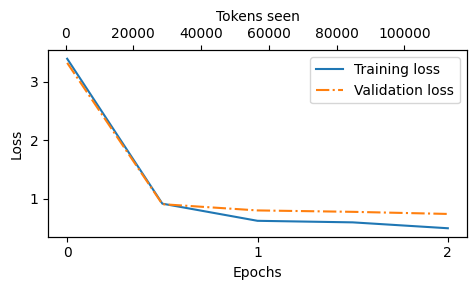

In [30]:
from previous_process import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

We can observe from the plot
- The training loss decreasing steeply over the first epoch indicating that the model has learned the representations in the data very well.
- However as we approach the end of the second epoch , the model's loss tends to stabilize indicating that it is converging to a stable solution


The alpaca dataset : https://huggingface.co/datasets/tatsu-lab/alpaca
- Consists of 52k instruction-output pairs


How to possibly deal with memory problems while training on large datasets like these
- Reduce batch size
- Reduce the `allowed_max_length`

In [35]:
#inspecting the responses manually

torch.manual_seed(42)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes as task. Write a response that approximately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes as task. Write a response that approximately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of thunderstorm is the Ursa Major.
-------------------------------------
Below is an instruction that describes as task. Write a response that approximately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is George Orwel

- Well the GPT-2 small model clearly doesn't to be working as good as we expect. Understandable considering it size , probably do we need to overtrain it to work to some extent , let me try it out again.
- Weird how compared to running it for 2 epochs , training it over 5 epochs does seem quite fine compared to the previous one.
    - Can we make the model really improve its capability for this size ? 
        - Need to read more about this.

### Evaluation:

In [36]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
        )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
        )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:21<00:00,  5.18it/s]


In [37]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [38]:
#save model
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)

print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth


In [28]:
# load the model and use it
from previous_process import GPTModel

model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load("gpt2-small124M-sft.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

We would now use Ollama to automate the evaluation process of the model. Would be using a powerful model Qwen3 , however would be using the quantized smaller version of the model due to memory limits.

In [29]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
    "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


We will serve the model using Ollama locally via an API to which we can send requests and interact with.

In [30]:
import urllib.request

def query_model(prompt,model="qwen3:0.6b",url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options" : {
            "seed" : 42,
            "temperature" : 0,
            "num_ctx" : 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url,data=payload,method="POST")
    request.add_header("Content-Type", "application/json")
    response_data = ""

    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

In [31]:
model = "qwen3:0.6b"
result = query_model("what is the capital of France?", model=model)
print(result)

<think>
Okay, the user is asking about the capital of France. I know that France is a country in Europe, and I remember that the capital is Paris. But wait, let me make sure. I've heard that sometimes there are other cities with similar names, but I don't think Paris is the capital. Maybe I should double-check. Oh, right! Paris is indeed the capital. Let me think if there's any other possibility. No, I don't think so. The capital is Paris. So the answer should be Paris.
</think>

The capital of France is **Paris**.


We can now use this as an LLM-as-a-judge concept where we prompt the model to evaluate the responses

In [33]:
with open("instruction-data-with-response.json", "r") as file:
    test_data = json.load(file)
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

In [35]:
for entry in test_data[:3]:
    prompt = (
    f"You are a helpful assitant who can score model responses"
    f"Given the input `{format_input(entry)} and correct output `{entry['output']}`, "
    f"score the model response given by the trained model`{entry['model_response']}`"
    f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> <think>
Okay, let's see. The user wants me to rewrite the sentence "The car is very fast." using a simile and then score the model response given by the trained model, which is "The car is as fast as a cheetah." on a scale from 0 to 100.

First, I need to check if the model's response uses a simile. The original instruction says to rewrite the sentence using a simile. The input sentence is "The car is very fast." So the model's response is "The car is as fast as a cheetah." which is a simile comparing the car to a cheetah. That's correct.

Now, the score is from 0 to 100. The user wants me to approximate the model response's score. Since the model's response is a simile, and the instruction is to complete the request, I need to evaluate how well the model's response meets the criteria. The correct simile is used, so the score should be high. Let me think of a possible 

Based on experimenting , got to come with a simple prompt that does the job of inspecting the responses and providing a score based on the quality of the response. We can now evaluate the responses of the trained model , however changes needs to be done to the prompt slightly
Since Qwen3 is a reasoning model
- we need to add the no_think to the end of the prompt to only return the responses
- Also create another function to make sure i would be able to extract only the score.

In [52]:
import re
from tqdm import tqdm

def extract_score(text):
    matches = re.findall(r"\b([0-9]{1,3})\b", text)
    for match in matches:
        num = int(match)
        if 0 <= num <= 100:
            return num
    return None


def extract_score_and_trace(response: str):
    think_match = re.search(r"<think>(.*?)</think>", response, re.DOTALL)
    trace = think_match.group(1).strip() if think_match else None
    matches = re.findall(r"\d{1,3}", response)
    if matches:
        score = int(matches[-1])
        if 0 <= score <= 100:
            return score, trace
    return None, trace


def generate_model_scores(json_data,json_key,model="qwen3:0.6b"):
    scores = []
    for entry in tqdm(json_data,desc='Scoring responses'):
        prompt = (
            f"You are a helpful assitant who can score model responses"
            f"Given the input `{format_input(entry)} and correct output `{entry['output']}`, "
            f"score the model response given by the trained model`{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Please return only the score as an integer without any additional text. /no_think"
            )
        raw_score = query_model(prompt, model)
        score = extract_score(raw_score)
        if score is not None:
            scores.append(score)
        else:
            print(f"Could not extract valid score: {raw_score}")
            continue
    return scores

In [46]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring responses: 100%|██████████| 110/110 [00:10<00:00, 10.96it/s]

Number of scores: 110 of 110
Average score: 86.44



Looking at the final average score , chances are you might feel the model is performing quite well. However here is the catch, i got to previosuly glance through the results generated after training the model and saw some aweful responses.(which is completely understandable).
Hence it would be better if we are able to store the "reasoning" aspect of this small model used, this is helpful
- Enable us to understand the capability of the model used as judge
- The prompt can be further improved to make the model judge better.


First let me start with improving the prompt a bit and check the results, before i can store the reasoning tokens.(We are severely memory constrained as well hence trying to make the maximum use, so can't download more bigger models which can take upto 16gb memory for inference)

In [54]:
prompt_judge = """
You are a helpful and precise assistant that evaluates the quality of model-generated responses.

You will be given:
- An input
- The correct (reference) output
- A response generated by a trained model

Your task is to assign a score from 0 to 100 based on how closely the model's response matches the reference output in terms of correctness, relevance, and completeness.

A score of:
- 100 means the response is correct and perfect to the reference output.
- 0 means it is completely incorrect or irrelevant to the expected output.

### Input:
{input_text}

### Reference Output:
{reference_output}

### Model Response:
{model_response}

Return only the score as an integer (no explanation, no formatting, no additional text).
"""

In [56]:
def generate_model_scores_v2(json_data, json_key, model="qwen3:0.6b"):
    evaluations = []
    scores = []
    for entry in tqdm(json_data, desc='Scoring responses'):
        formatted_prompt = prompt_judge.format(
            input_text=format_input(entry),
            reference_output=entry['output'],
            model_response=entry[json_key]
        )
        raw_score = query_model(formatted_prompt, model)
        score,trace = extract_score_and_trace(raw_score)
        eval_entry = {
            "instruction": entry["instruction"],
            "input": entry["input"],
            "output": entry['output'],
            "model_response": entry[json_key],
            "trace": trace if trace else "N/A",
            "score": score if score is not None else "INVALID"
        }

        evaluations.append(eval_entry)
        if score is not None:
            scores.append(score)
        else:
            print(f"Could not extract valid score: {raw_score}")
    
    with open("inspect_eval.json", "w") as f:
        json.dump(evaluations, f, indent=2)
        
    return scores

scores = generate_model_scores_v2(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring responses: 100%|██████████| 110/110 [01:59<00:00,  1.09s/it]

Number of scores: 110 of 110
Average score: 25.41



With the improved prompt , we can see eval process to be more strict and better.
This entire pipeline can be improved and more experiments can be conducted. Changes that can be made :
- Finetuning the hyper-parameters
- Increasing the base-model size and fine-tuning it
- Updating the judge model (bigger size more capabilities present(not always true)) and changing the prompt (continous refinement) 